In [2]:
import os, sys
import tqdm
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import yaml
from numpy import random
import sys

#sys.path.append("../")

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [226]:
import importlib

In [229]:
from holodec.datasets import UpsamplingReader
# import holodec

In [228]:
importlib.reload(holodec.datasets)

NameError: name 'holodec' is not defined

In [10]:
# load file path information from the home directory
dirP_str = os.path.join(os.environ["HOME"], "Python","miles-holodec")
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [213]:
# from torch.utils.data import Dataset
# from holodec.transforms import LoadTransformations
# from holodec.propagation import WavePropagator
# from holodec.propagation import UpsamplingPropagator
# import yaml
# import math
# import torch
# import numpy as np
# import random

class UpsamplingReader(Dataset):
    def __init__(
        self,
        file_path,
        n_bins=1000,
        shuffle=False,
        device="cpu",
        transform=None,
        lookahead=2,  # this is really the number of planes
        step_size=32,
        tile_size=32,
        balance=True,
        output_lst=None,  # output functions to apply to complex field (abs, real, imag)
        deweight=1e-3,  # deweighting applied to nonparticle pixels in weight mask
        pad=False,  # Only true when using full-sized images
        random_tile=False,
        count_per_holo= 10,  # number of particles to train on from each hologram
        sig_z = 10,
        sig_x = 0,
        sig_y = 0,
    ):

        self.count_per_holo = count_per_holo
        self.sig_z = sig_z # variance in z in microns
        self.sig_x = sig_x # variance in z in microns
        self.sig_y = sig_y # variance in z in microns

        # num of waveprop windows
        self.n_bins = n_bins
        # device used
        self.device = device
        # shuffle frames
        self.shuffle = shuffle
        # number of planes to reconstruct around the z position
        # for this class lookahead must be 2 or more
        assert lookahead > 1
        self.lookahead = lookahead
        self.z_bck_idx = int(np.floor((self.lookahead-1)/2))  # planes back from indexed plane
        self.z_fwd_idx = int(np.ceil((self.lookahead-1)/2))+1  # planes in front of indexed plane
        # wavepropagator object on device
        self.propagator = WavePropagator(
            file_path,
            n_bins=n_bins,
            device=device,
            step_size=step_size,
            tile_size=tile_size,
        )
        self.transform = transform
        if self.transform is not None:
            self.pre_waveprop_transformations = pre_waveprop_transformations

        self.part_lst = []
        for h_idx in self.propagator.h_ds.hologram_number.values:
            hid = h_idx + 1
            hid_mask = self.propagator.h_ds["hid"] == hid
            hid_p_idx = np.where(hid_mask)[0]

            idx_arr = np.random.choice(hid_p_idx,size=self.count_per_holo,replace=False)

            # Filter particles based on h_idx
            x_part = self.propagator.h_ds["x"].values[idx_arr]
            y_part = self.propagator.h_ds["y"].values[idx_arr]
            z_part = self.propagator.h_ds["z"].values[idx_arr]
            d_part = self.propagator.h_ds["d"].values[idx_arr]

            # add particle data tuple to particle list
            self.part_lst.extend([
             (h_idx,) + pdat for pdat in zip(x_part, y_part, z_part, d_part)
            ])
            
            # self.indices.append([(x,y,z,d)])
            # self.indices.append((h_idx*np.ones(idx_arr.size), x_part, y_part, z_part, d_part))

            # x_part = self.propagator.h_ds["x"].values[idx_arr] + np.random.randn(len(idx_arr))*self.sig_x
            # y_part = self.propagator.h_ds["y"].values[idx_arr] + np.random.randn(len(idx_arr))*self.sig_y
            # z_part = self.propagator.h_ds["z"].values[idx_arr] + np.random.randn(len(idx_arr))*self.sig_z

            


        # self.indices = [
        #     (x, y)
        #     for x in self.propagator.h_ds.hologram_number
        #     for y in range(self.z_bck_idx, self.n_bins - self.z_fwd_idx)
        #     #for y in range(self.n_bins - self.lookahead)
        # ]

        self.tile_size = tile_size
        self.step_size = step_size

        if output_lst is None:
            self.output_lst = [torch.abs, torch.angle]
        else:
            self.output_lst = output_lst

        self.deweight = deweight
        self.pad = pad
        self.create_mapping()
        self.random_tile = random_tile

    def __len__(self):
        return len(self.part_lst)

    def create_mapping(self):
        """
        Generate slices for tiling a full-size image.

        Args:
            full_height (int): Height of the full-size image.
            full_width (int): Width of the full-size image.
            tile_size (tuple): Size of each tile in the format (tile_height, tile_width).
            stride_size (tuple): Stride between adjacent tiles in the format (vertical_stride, horizontal_stride).

        Returns:
            list: List of slices for each tile.
        """
        self.idx2slice = {}
        self.idx2center = {}
        full_height = self.propagator.Nx
        full_width = self.propagator.Ny
        tile_height, tile_width = self.tile_size, self.tile_size
        vertical_stride, horizontal_stride = self.step_size, self.step_size

        # Calculate the number of tiles in each dimension
        num_vertical_tiles = math.floor((full_height - tile_height) / vertical_stride) + 1
        num_horizontal_tiles = math.floor((full_width - tile_width) / horizontal_stride) + 1

        # Iterate over tiles and generate slices
        count = 0
        for i in range(num_vertical_tiles):
            for j in range(num_horizontal_tiles):
                # Calculate starting indices for each tile
                start_vertical = i * vertical_stride
                start_horizontal = j * horizontal_stride

                # Adjust tile size to handle edge cases
                tile_height_adj = min(tile_height, full_height - start_vertical)
                tile_width_adj = min(tile_width, full_width - start_horizontal)

                # Generate the slice for the tile
                tile_slice = (slice(start_vertical, start_vertical + tile_height_adj),
                              slice(start_horizontal, start_horizontal + tile_width_adj))

                # Append the slice to the list
                self.idx2slice[count] = tile_slice
                self.idx2center[count] = [self.propagator.x_arr[start_vertical + tile_width//2],
                                          self.propagator.y_arr[start_horizontal + tile_height//2]]
                # self.idx2center[count] = {'x': self.propagator.x_arr[start_vertical + tile_width//2],
                #                           'y': self.propagator.y_arr[start_horizontal + tile_height//2]}
                count += 1

    def __getitem__(self, idx):
        if self.shuffle:
            idx = random.choice(range(self.__len__()))

        h_idx, x_part, y_part, z_part, d_part = self.part_lst[idx]
        z_idx = np.argmin(np.abs(self.propagator.z_centers-(z_part+np.random.randn()*self.sig_z)))
        print(z_idx)
        
        # h_idx, z_idx = self.indices[idx]

        # Select hologram
        image = self.propagator.h_ds["image"].isel(hologram_number=h_idx).values.astype(float)
        image = torch.from_numpy(image).to(self.device)

        # Apply noise transformations to the original image before wave-prop
        if self.transform is not None:
            im = {'image': image}
            for image_transform in self.transform:
                if image_transform.__class__.__name__ in self.pre_waveprop_transformations:
                    im = image_transform(im)
            image = im['image']

        # Wave-prop
        image = self._propagate_hologram(image, z_idx)

        # Apply output functions to the propagated hologram
        in_channels = self._apply_output_functions(image)

        # Create masks
        num_particles, part_mask, depth_mask, weight_mask = self.create_mask(h_idx, z_idx)

        if self.transform is not None:

            stacked_masks = torch.stack([part_mask, depth_mask, weight_mask], dim=0)

            im = {
                "image": in_channels,
                "mask": stacked_masks
            }

            for image_transform in self.transform:
                if image_transform.__class__.__name__ not in self.pre_waveprop_transformations:
                    im = image_transform(im)

            in_channels = im['image'].float()
            part_mask = im['mask'][0, :, :]
            depth_mask = im['mask'][1, :, :]
            weight_mask = im['mask'][2, :, :]

        # Rescale the depth by the delta z value in centimeters
        depth_mask /= (self.propagator.z_centers[1]-self.propagator.z_centers[0])

        # Pad images and masks if using full sized holograms
        if self.pad:
            in_channels, part_mask, depth_mask, weight_mask = self.pad_images_and_mask(
                in_channels, part_mask, depth_mask, weight_mask)

        # Select a tile
        if self.random_tile:
            idx = random.choice(list(self.idx2slice.values()))
            x_slice, y_slice = idx[0], idx[1]
            return in_channels[..., x_slice, y_slice].squeeze(0), part_mask[x_slice, y_slice], depth_mask[x_slice, y_slice], weight_mask[x_slice, y_slice]
        else:
            rand_x = np.random.randn()*self.sig_x
            rand_y = np.random.randn()*self.sig_y
            # min_idx = 0
            # min_val = 1e20
            dist_2 = np.sum((np.array(list(self.idx2center.values())) - 1e-6*np.array([[x_part+rand_x,y_part+rand_y]]))**2,axis=1)
            min_idx = np.argmin(dist_2)
            print(f"particle: {x_part}, {y_part}")
            print(f"slice: {self.idx2center[min_idx][0]*1e6}, {self.idx2center[min_idx][1]*1e6}")
            # for idx in self.idx2center:
            #     dist_2 = (self.idx2center[idx]['x']-(x_part+rand_x))**2 + (self.idx2center[idx]['y']-(y_part+rand_y))**2
            #     if dist_2 < min_val:
            #         min_idx = idx
            #         min_val = dist_2
            x_slice = self.idx2slice[min_idx][0]
            y_slice = self.idx2slice[min_idx][1]
            return in_channels[..., x_slice, y_slice].squeeze(0), part_mask[x_slice, y_slice], depth_mask[x_slice, y_slice], weight_mask[x_slice, y_slice]
                
        return in_channels.squeeze(0), part_mask, depth_mask, weight_mask

    def _propagate_hologram(self, image, z_idx):
        z_slc = slice(z_idx - self.z_bck_idx, z_idx + self.z_fwd_idx)
        image = self.propagator.torch_holo_set(
            image,
            torch.FloatTensor([self.propagator.z_centers[z_slc, np.newaxis, np.newaxis] * 1e-6]).to(self.device)
        )
        return image

    def _apply_output_functions(self, image):
        image = image.to(dtype=torch.complex64) # as of v2.2.0 abs and angle do not support complex128
        ch_lst = [fnc(image) for fnc in self.output_lst]
        in_channels = torch.cat(ch_lst, dim=1)  # Stack the channels along the z-planes
        return in_channels

    def create_mask(self, h_idx, z_idx):

        hid = h_idx + 1
        hid_mask = self.propagator.h_ds["hid"] == hid

        # Filter particles based on h_idx
        x_part = self.propagator.h_ds["x"].values[hid_mask]
        y_part = self.propagator.h_ds["y"].values[hid_mask]
        z_part = self.propagator.h_ds["z"].values[hid_mask]
        d_part = self.propagator.h_ds["d"].values[hid_mask]

        # z_indices = np.digitize(z_part, self.propagator.z_bins) - 1
        # Initialize the UNET mask
        unet_mask = np.zeros((self.propagator.x_arr.shape[0], self.propagator.y_arr.shape[0]))
        depth_mask = np.zeros((self.propagator.x_arr.shape[0], self.propagator.y_arr.shape[0]))
        weight_mask = np.zeros((self.propagator.x_arr.shape[0], self.propagator.y_arr.shape[0]))+self.deweight

        num_particles = 0

        # find particles that are contained between the first and last planes
        cond = np.where((z_part >= self.propagator.z_centers[z_idx-self.z_bck_idx]) & \
                        (z_part <= self.propagator.z_centers[z_idx+self.z_fwd_idx]))

        # if z_idx in z_indices:
        # cond = np.where(z_idx == z_indices)
        if np.size(cond[0]) > 0:
            x_part = x_part[cond]
            y_part = y_part[cond]
            z_part = z_part[cond]
            d_part = d_part[cond]

            # Build the UNET mask using vectorized operations
            for part_idx in range(len(cond[0])):
                z_diff = z_part[part_idx] - self.propagator.z_centers[z_idx] # z distance from reference plane
                y_diff = (self.propagator.y_arr[None, :] * 1e6 - y_part[part_idx])
                x_diff = (self.propagator.x_arr[:, None] * 1e6 - x_part[part_idx])
                d_squared = (d_part[part_idx] / 2)**2
                part_pxl_idx = np.where((y_diff**2 + x_diff**2) < d_squared)
                unet_mask[part_pxl_idx] = 1.0
                # unet_mask += ((y_diff**2 + x_diff**2) < d_squared).astype(float)
                depth_mask[part_pxl_idx] = z_diff
                weight_pxl_idx = np.where((y_diff**2 + x_diff**2) < 4*d_squared)
                weight_mask[weight_pxl_idx] = 1.0
                num_particles += 1

        return num_particles, torch.from_numpy(unet_mask), torch.from_numpy(depth_mask), torch.from_numpy(weight_mask)

    def get_particle(self, h_idx):
        indices = np.where(self.propagator.h_ds["hid"] == h_idx + 1)
        d_locations = self.propagator.h_ds["d"].values[indices]
        x_locations = self.propagator.h_ds["x"].values[indices]
        y_locations = self.propagator.h_ds["y"].values[indices]
        z_locations = self.propagator.h_ds["z"].values[indices]

        xp = np.digitize(x_locations, 1e6 * self.propagator.x_arr, right=True)
        yp = np.digitize(y_locations, 1e6 * self.propagator.y_arr, right=True)
        zp = z_locations
        dp = d_locations

        for (x, y, z, d) in zip(xp, yp, zp, dp):
            yield x, y, z, d

    def pad_images_and_mask(self, image_stack, mask1, mask2, mask3, target_height=4896, target_width=3264):
        """
        Pad the image_stack and mask with zeros to sizes (num_images, channels, 4896, 3264) and (4896, 3264) respectively using PyTorch.

        Parameters:
            image_stack (torch.Tensor): The input image stack with shape (num_images, channels, height, width).
            mask (torch.Tensor): The input mask with shape (height, width).

        Returns:
            tuple: A tuple containing the padded image_stack and mask as torch.Tensors.
        """
        current_height, current_width = image_stack.size(-2), image_stack.size(-1)
        pad_height = max(target_height - current_height, 0)
        pad_width = max(target_width - current_width, 0)

        # Pad the image_stack
        mean_image = 0 #torch.mean(image_stack)
        padded_image_stack = torch.nn.functional.pad(image_stack, (0, pad_width, 0, pad_height), mode='constant', value=mean_image)

        # Pad the mask
        padded_mask1 = torch.nn.functional.pad(mask1, (0, pad_width, 0, pad_height), mode='constant', value=0)
        padded_mask2 = torch.nn.functional.pad(mask2, (0, pad_width, 0, pad_height), mode='constant', value=0)
        padded_mask3 = torch.nn.functional.pad(mask3, (0, pad_width, 0, pad_height), mode='constant', value=0)

        return padded_image_stack, padded_mask1, padded_mask2, padded_mask3

In [215]:
transforms = {
    'RandomVerticalFlip': {'rate': 0.0},
    'RandomHorizontalFlip': {'rate': 0.0},
    #'Normalize': {'mode': '255'},
    #'GaussianBlur': {'rate': 1.0, 'kernel_size': 1, 'sigma': 2.1252219359742823},
    #'GaussianNoise': {'rate': 1.0, 'noise': 0.3258530643453389},
    #'AdjustBrightness': {'rate': 1.0, 'brightness_factor': 1.269735791766263}
}

In [219]:
with open("../config/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

lookahead = 5 #int(conf["data"]["lookahead"])
conf["model"]["in_channels"] = 2 * (lookahead + 1)

n_bins = 100 #int(conf["data"]["n_bins"])
tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])

train_dataset = UpsamplingReader(
    "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc", 
    shuffle = False, 
    device = device, 
    n_bins = n_bins, 
    # transform = LoadTransformations(transforms),
    #transform = [RandVerticalFlip(1.0), RandHorizontalFlip(1.0)], 
    lookahead = lookahead, 
    tile_size = tile_size, 
    step_size = step_size,
    output_lst = [torch.abs, torch.angle],
    deweight = 1e-6,  # amount to deweight empty pixels in the loss function (through the weight mask)
    random_tile=False,
    sig_z = 10,
)

In [223]:
# random_integer = random.randint(0, train_dataset.__len__())
random_integer = 145
print("Id", random_integer)
x, y1, y2, y3 = train_dataset.__getitem__(random_integer)
print(x.shape, y1.shape, y2.shape, y3.shape)
x = x.unsqueeze(0)
print("Particl Mask sum", y1.sum())
print("Depth Mask sum", y2.sum())
print("Weight Mask sum", y3.sum())

Id 145
3
particle: 5469.814453125, -3900.5849609375
slice: 5292.4800000000005, -4049.2799999999997
torch.Size([10, 512, 512]) torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 512])
Particl Mask sum tensor(243., dtype=torch.float64)
Depth Mask sum tensor(17.5472, dtype=torch.float64)
Weight Mask sum tensor(981.2612, dtype=torch.float64)


Text(0.5, 1.0, 'Weight Mask')

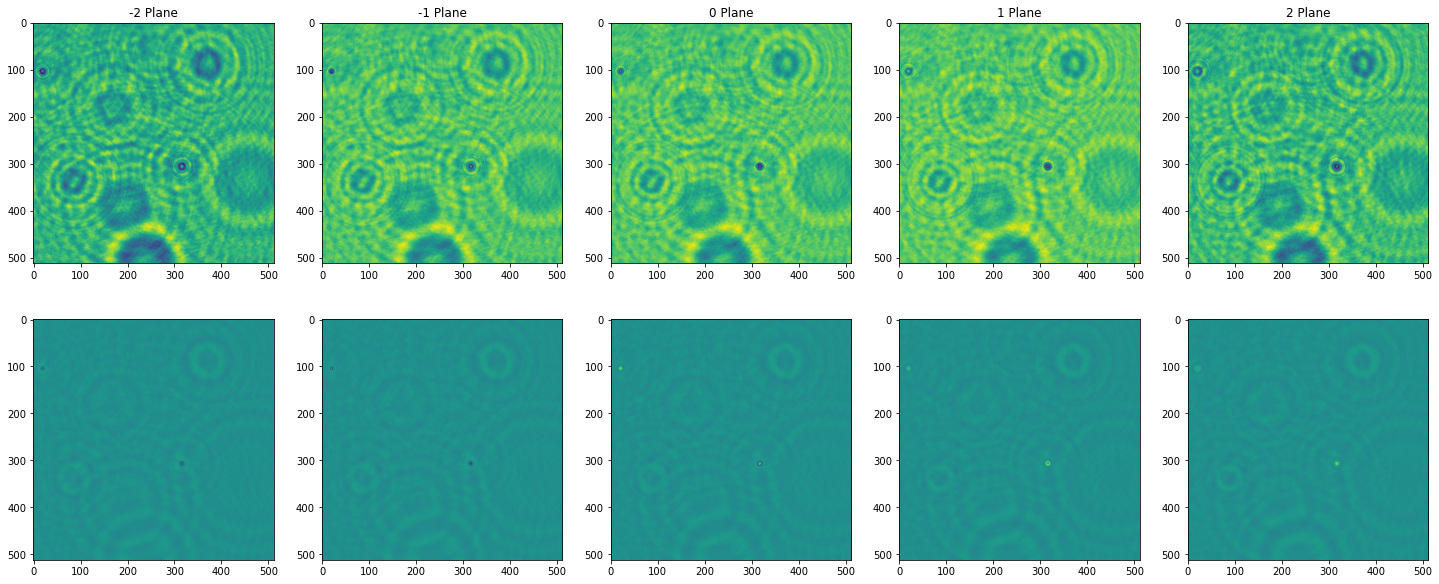

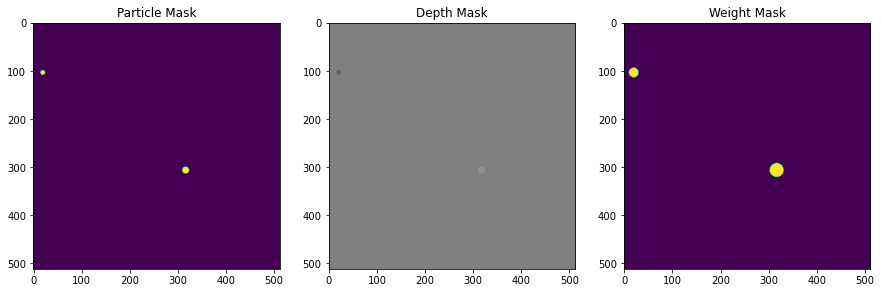

In [224]:
fig, ax_lst = plt.subplots(2,lookahead,figsize=(5*lookahead,10))

# rw_slc = slice(0, 1000)
# cl_slc = slice(0, 1000)

rw_slc = slice(None, None)
cl_slc = slice(None, None)

# plot the multi plane stack
for pln_idx in range(lookahead):
    ax = ax_lst[0,pln_idx]
    ax.imshow(x[0,pln_idx,rw_slc,cl_slc].detach().cpu().numpy().T)
    ax.set_title(f"{pln_idx-train_dataset.z_bck_idx} Plane")
    ax = ax_lst[1,pln_idx]
    ax.imshow(x[0,pln_idx+lookahead,rw_slc,cl_slc].detach().cpu().numpy().T, vmin=-np.pi,vmax=np.pi)

# plot the mask outputs
fig,ax_lst = plt.subplots(1,3,figsize=(15,5))
ax = ax_lst[0]
ax.imshow(y1[rw_slc, cl_slc].detach().cpu().numpy().T,vmin=0,vmax=1)
ax.set_title("Particle Mask")

ax = ax_lst[1]
ax.imshow(y2[rw_slc, cl_slc].detach().cpu().numpy().T,vmin=-3,vmax=3,cmap='gray')
ax.set_title("Depth Mask")

ax = ax_lst[2]
ax.imshow(y3[rw_slc, cl_slc].detach().cpu().numpy().T)
ax.set_title("Weight Mask")

In [174]:
train_dataset.propagator.dz

AttributeError: 'WavePropagator' object has no attribute 'dz'

In [111]:
train_dataset.create_mapping()

770


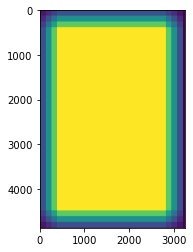

In [112]:
total = 0
patch_count = torch.zeros(train_dataset.propagator.Nx, train_dataset.propagator.Ny)
for slices in train_dataset.idx2slice.values():
    patch_count[slices] += 1
    total += 1
print(total)
plt.imshow(patch_count)

In [ ]:
list(self.idx2slice.values())

In [146]:
np.array(list(train_dataset.idx2center.values())).shape

(770, 2)

In [147]:
np.array([[0,1]]).shape

(1, 2)

In [ ]:
(patch_count > 0).float().mean()

In [40]:
train_dataset.propagator.z_centers[1]-train_dataset.propagator.z_centers[0]

1440.0

In [11]:
x.shape

torch.Size([10, 4872, 3248])

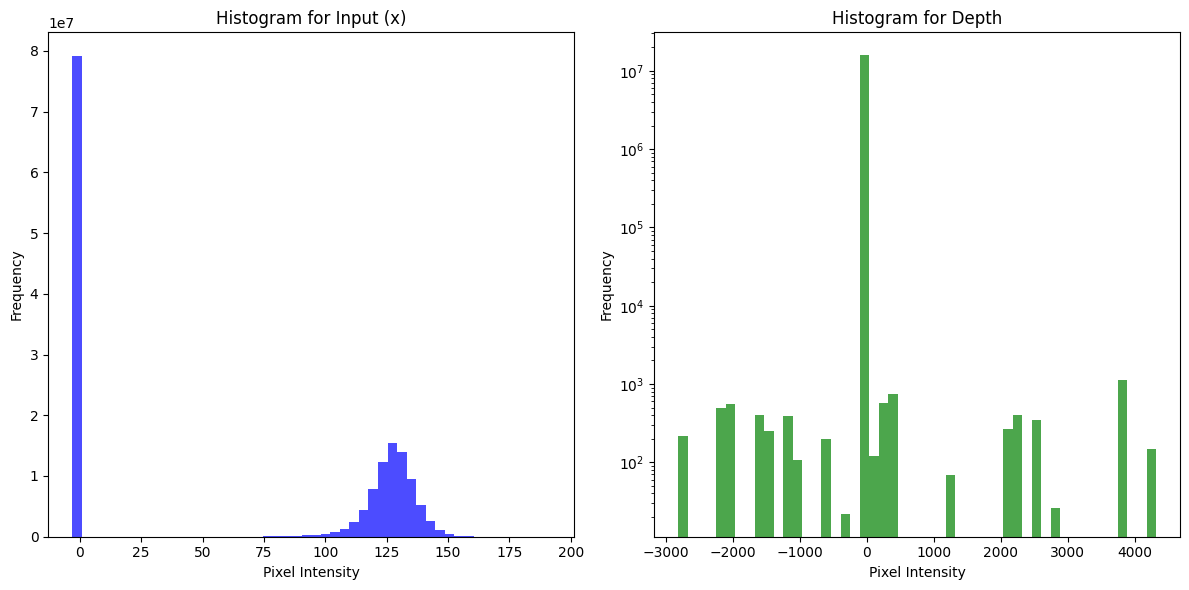

In [20]:
# Flatten the color channels
x_flat = x.view(-1).cpu().numpy()
y_flat = y2.view(-1).cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for input x
plt.subplot(1, 2, 1)
plt.hist(x_flat, bins=50, color='blue', alpha=0.7)
plt.title('Histogram for Input (x)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Histogram for depth mask y3
plt.subplot(1, 2, 2)
plt.hist(y_flat, bins=50, color='green', alpha=0.7)
plt.title('Histogram for Depth')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Number of additional data points
num_additional_points = 10

# Accumulate data points
x_accumulator = []
y_accumulator = []

for _ in range(num_additional_points):
    x, _, y, _ = train_dataset.__getitem__(random_integer)
    x_accumulator.append(x.view(-1).cpu().numpy())
    y_accumulator.append(y.view(-1).cpu().numpy())

# Flatten and concatenate
x_flat = np.concatenate(x_accumulator)
y_flat = np.concatenate(y_accumulator)

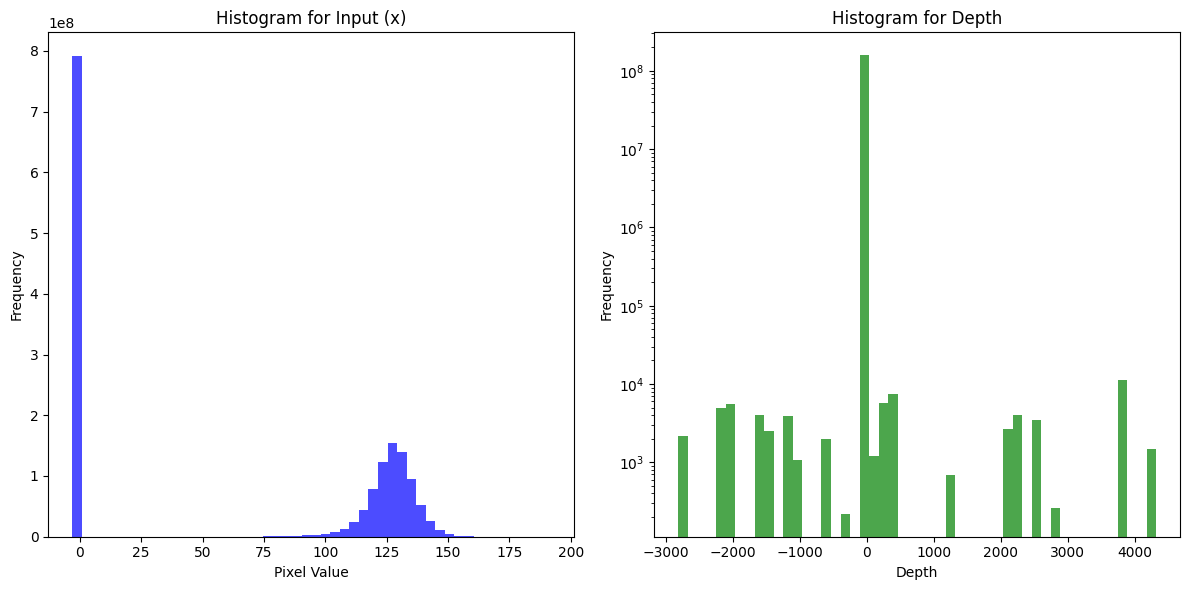

In [27]:
# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for input x
plt.subplot(1, 2, 1)
plt.hist(x_flat, bins=50, color='blue', alpha=0.7)
plt.title('Histogram for Input (x)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Histogram for depth mask y2
plt.subplot(1, 2, 2)
plt.hist(y_flat, bins=50, color='green', alpha=0.7)
plt.title('Histogram for Depth')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()


In [29]:
min(y_flat)

-2820.98046875